In [1]:
!pip install einops

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [3]:
import os
import torch
from torch import nn
import nibabel as nib
from torch.utils.data import Dataset, DataLoader, random_split
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    NormalizeIntensityd,
    Compose,
    CenterSpatialCropd
)
from monai.networks.nets import SwinUNETR, ResNetFeatures
from monai.losses import DiceLoss
from torch.optim import Adam
from monai.metrics import DiceMetric
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm
import gc
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler, LabelEncoder
import random
import warnings

2025-06-04 16:37:06.065545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749055026.291281      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749055026.355500      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
warnings.filterwarnings("ignore")

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(31)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
BATCH_SIZE = 4
EPOCHS = 70

In [8]:
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    RandSpatialCropd(keys=["image"], roi_size=[96, 96, 96], random_size=False),
    RandFlipd(keys=["image"], spatial_axis=0, prob=0.1),
    RandFlipd(keys=["image"], spatial_axis=1, prob=0.1),
    RandFlipd(keys=["image"], spatial_axis=2, prob=0.1),
    RandRotate90d(keys=["image"], max_k=3, prob=0.1),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

# train_transforms = Compose([
#     LoadImaged(keys=["image"]),
#     EnsureChannelFirstd(keys=["image"]),
#     EnsureTyped(keys=["image"]),
#     CenterSpatialCropd(keys=["image"], roi_size=[96, 96, 96]),
#     NormalizeIntensityd(keys="image", nonzero=False, channel_wise=True)
# ])

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    CenterSpatialCropd(keys=["image"], roi_size=[96, 96, 96]),
    NormalizeIntensityd(keys="image", nonzero=False, channel_wise=True)
])

In [9]:
class BrainDataset(Dataset):
    def __init__(self,cognitive_csv_path, dir_path, transform = None):
        super().__init__()
        self.transform = transform
        self.df_cognitive = pd.read_csv(cognitive_csv_path)
        self.dir_path = dir_path
        
        # le = LabelEncoder()
        # self.df_cognitive['PTGENDER'] = le.fit_transform(self.df_cognitive['PTGENDER'])
        
    def __len__(self):
        return len(self.df_cognitive)
    def __getitem__(self, index):
        image_id = self.df_cognitive.iloc[index]['image_id']
        string_image_id = 'I' + str(image_id)
        img_path = os.path.join(self.dir_path, string_image_id, "T1_biascorr_brain.nii")
        
        clinical = self.df_cognitive.iloc[index][['PTGENDER','PTEDUCAT','age','DIAGNOSIS_now']]
        clinical = clinical.astype('float32').values
        clinical = torch.tensor(clinical, dtype=torch.float32)

        time_lapse = self.df_cognitive.iloc[index]['time_lapsed']
        time_lapse = torch.tensor(time_lapse, dtype=torch.float32)
        
        label = self.df_cognitive.iloc[index][['ADAS11_now','ADAS13_now','MMSCORE_now','ADAS11_future','ADAS13_future','MMSCORE_future']]
        label = label.astype('float32').values
        label = torch.tensor(label, dtype=torch.float32)
        
        sample =  {"image": img_path}
        
        if self.transform:
            sample = self.transform(sample)
        mri = sample['image']
        return (mri, clinical, time_lapse), label

In [11]:
traindataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/train_6_18.csv", 
                            dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                            transform = train_transforms)

valdataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/val_6_18.csv", 
                          dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                          transform = val_transforms)

testdataset = BrainDataset(cognitive_csv_path = "/kaggle/input/extended-brain-data/test_6_18.csv", 
                          dir_path = "/kaggle/input/fsl-brain-dataset/T1_biascorr_brain_data", 
                          transform = val_transforms)

In [12]:
train_loader = DataLoader(traindataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(valdataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(testdataset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
print(len(train_loader), len(val_loader), len(test_loader))

275 31 31


In [ ]:
dataframe = traindataset.df_cognitive

In [ ]:
dataframe.head()

In [ ]:
(mri, clinical, time_lapse), label = next(iter(train_loader))
print(mri.shape)
print(clinical)
print(time_lapse.shape)
print(label)

In [ ]:
# class ClinicalEncoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.encoder =  nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.LeakyReLU(0.01),
#             nn.Linear(hidden_dim, output_dim),
#             # nn.LeakyReLU(0.01) # test xem biểu diễn phức tạp hay đơn giản tốt hơn
#         )
#     def forward(self, x):
#         return self.encoder(x)

# class MRIEncoder(nn.Module):
#     def __init__(self, model_name = "resnet18", pretrained = True):
#         super().__init__()
#         self.resnet = ResNetFeatures(
#                         model_name=model_name,    
#                         pretrained=True,          
#                         spatial_dims=3,           
#                         in_channels=1             
#                     )
#         self.pool = nn.AdaptiveAvgPool3d((1,1,1))

#     def forward(self, x):
#         features = self.resnet(x)[-1]
#         pooled_features = self.pool(features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1)
#         # return self.pool(self.resnet(x)[-1])
#         return pooled_features

# class ADRegression(nn.Module):
#     def __init__(self, 
#                  clinic_input_dim, 
#                  clinic_hidden_dim, 
#                  clinic_output_dim, 
#                  model_name,
#                  fusion_hidden_dim,
#                  output_dim,
#                  pretrained = True):
#         super().__init__()
#         self.clinical_encoder = ClinicalEncoder(clinic_input_dim, clinic_hidden_dim, clinic_output_dim)
#         self.mri_encoder = MRIEncoder(model_name, pretrained)
#         self.regressor = nn.Sequential(
#             nn.Linear(clinic_output_dim + 512, fusion_hidden_dim),
#             nn.ReLU(),                      
#             nn.Linear(fusion_hidden_dim, output_dim)
#         )
#     def forward(self, mri_input, clinical_input):
#         mri_features = self.mri_encoder(mri_input)
#         clinical_features = self.clinical_encoder(clinical_input)
#         fused_features = torch.concat((mri_features, clinical_features), dim = 1)
#         return self.regressor(fused_features)

In [14]:
class MRIEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze = True, model_name="resnet50"):
        super().__init__()
        self.encoder = ResNetFeatures(
                model_name=model_name,    
                pretrained=True,          
                spatial_dims=3,           
                in_channels=1             
        )

        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        if freeze:
            print("Freezing mri encoder")
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)[-1]
        pooled = self.pool(features).view(features.size(0), -1)
        return pooled

class ADRegression(nn.Module):
    def __init__(self,
                 clinic_input_dim,
                 clinic_hidden_dim,
                 clinic_output_dim,
                 fusion_hidden_dim,
                 output_dim,
                 pretrained=True,
                 freeze = True):
        super().__init__()

        # self.clinical_encoder = ClinicalEncoder(
        #     clinic_input_dim, clinic_hidden_dim, clinic_output_dim)

        self.mri_encoder = MRIEncoder(pretrained, freeze)

        self.mri_head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
        
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
        
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
        )
        
        self.future_demo = nn.Sequential(
            nn.Linear(clinic_input_dim, clinic_hidden_dim),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(clinic_hidden_dim, clinic_output_dim)
        )
        
        self.adas11_future = nn.Sequential(
            nn.Linear(256 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, 1)  
        )

        self.adas13_future = nn.Sequential(
            nn.Linear(256 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, 1) 
        )

        self.mmscore_future = nn.Sequential(
            nn.Linear(256 + 64, fusion_hidden_dim),
            nn.Softplus(),
            nn.Dropout(0.3),
            nn.Linear(fusion_hidden_dim, 1)  
        )

    def forward(self, mri_input, clinical_input, time_lapse, y_now):

        mri_features = self.mri_encoder(mri_input)
        mri_features = self.mri_head(mri_features)
        # clinical_features = self.clinical_encoder(clinical_input)

        future_features = torch.cat((clinical_input, time_lapse, y_now), dim = 1)
        future_features = self.future_demo(future_features)  # B x 32
        fused_future = torch.cat((mri_features, future_features), dim=1)
        adas11_future = self.adas11_future(fused_future)
        adas13_future = self.adas13_future(fused_future)
        mmscore_future = self.mmscore_future(fused_future)
    
        return adas11_future, adas13_future, mmscore_future

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, threshold_std=1.0, outlier_weight=2.0, reduction='mean', device=None):
        super().__init__()
        self.threshold_std = threshold_std
        self.outlier_weight = outlier_weight
        self.reduction = reduction
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.smooth_l1 = nn.SmoothL1Loss(reduction='none')

    def forward(self, preds, targets):
        """
        preds, targets: tensors shape (B, N)
        """
        abs_error = (preds - targets).abs()

        # Tính std dev theo batch cho từng output (column)
        std_per_output = targets.std(dim=0, keepdim=True)  # shape (1, N)

        # Xác định outliers
        is_outlier = abs_error > (self.threshold_std * std_per_output)

        # Gán trọng số cho từng phần tử
        weights = torch.ones_like(abs_error, device=preds.device)
        weights[is_outlier] = self.outlier_weight

        # Tính Smooth L1 loss từng phần tử
        loss_raw = self.smooth_l1(preds, targets)

        # Nhân trọng số
        weighted_loss = loss_raw * weights

        # Reduction
        if self.reduction == 'mean':
            return weighted_loss.mean()
        elif self.reduction == 'sum':
            return weighted_loss.sum()
        else:
            return weighted_loss

In [ ]:
def train_one_epoch(model, optimizer, loss_fn, train_loader, scaler, device=device):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    total_loss = 0.0
    
    for batch_idx, ((mri, clinical, time_lapse), y) in pbar:
        mri = mri.to(device)
        clinical = clinical.to(device)
        time_lapse = time_lapse.to(device)
        y = y.to(device)

        adas11_future = y[:, 3].unsqueeze(1)
        adas13_future = y[:, 4].unsqueeze(1)
        mmscore_future = y[:, 5].unsqueeze(1)

        y_now = y[:,0:3]
        # print(y_now.shape)

        with torch.amp.autocast(device_type=device):
            preds = model(mri, clinical, time_lapse.unsqueeze(1), y_now)
            (
                adas11_pred_future,
                adas13_pred_future,
                mmscore_pred_future,
            ) = preds

            loss_adas11_future = loss_fn(adas11_pred_future, adas11_future)
            loss_adas13_future = loss_fn(adas13_pred_future, adas13_future)
            loss_mmscore_future = loss_fn(mmscore_pred_future, mmscore_future)

            loss = (
                loss_adas11_future +
                loss_adas13_future +
                loss_mmscore_future 
            )

            # if torch.isnan(loss):
            #     print(f"Loss is NaN at batch {batch_idx}")

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        avg_loss = total_loss / (batch_idx + 1)
        pbar.set_postfix(loss=avg_loss)


In [ ]:
model =  ADRegression(clinic_input_dim = 8, 
                 clinic_hidden_dim = 32, 
                 clinic_output_dim = 64,
                 fusion_hidden_dim = 64,
                 output_dim = 2,
                 pretrained = True,
                 freeze = True).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=5e-5 
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # giảm LR xuống 30% mỗi khi plateau
    patience=4,      # đợi 3 epoch không cải thiện mới giảm
    threshold=1e-4,  # ngưỡng để xem có cải thiện hay không
    min_lr=1e-12,     # LR nhỏ nhất
    verbose=True
)
loss_fn = WeightedSmoothL1Loss(reduction = "mean").to(device)
scaler = torch.amp.GradScaler()

In [ ]:
best_loss = float('inf')  # Ban đầu đặt loss tốt nhất là vô cùng

In [ ]:
print(

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    print("Current LR:", optimizer.param_groups[0]['lr'])
    train_one_epoch(model, optimizer, loss_fn, train_loader, scaler, device=device)
    model.eval()
    total_loss = 0.0
    count = 0
    pbar = tqdm(enumerate(val_loader), leave=True)

    with torch.inference_mode():
        for batch_idx, ((mri, clinical, time_lapse), y) in pbar:
            mri = mri.to(device)
            clinical = clinical.to(device)
            time_lapse = time_lapse.to(device)
            y = y.to(device)

            adas11_future = y[:, 3].unsqueeze(1)
            adas13_future = y[:, 4].unsqueeze(1)
            mmscore_future = y[:, 5].unsqueeze(1)

            y_now = y[:,0:3]
    
            with torch.amp.autocast(device_type=device):
                preds = model(mri, clinical, time_lapse.unsqueeze(1), y_now)
                (
                    adas11_pred_future,
                    adas13_pred_future,
                    mmscore_pred_future,
                ) = preds
    
                loss_adas11_future = loss_fn(adas11_pred_future, adas11_future)
                loss_adas13_future = loss_fn(adas13_pred_future, adas13_future)
                loss_mmscore_future = loss_fn(mmscore_pred_future, mmscore_future)
    
                loss = (
                        loss_adas11_future +
                        loss_adas13_future +
                        loss_mmscore_future)

            total_loss += loss.item()
            count += 1
            pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / count
    print(f"Epoch {epoch}: Avg Test Loss = {avg_loss:.4f}")
    scheduler.step(avg_loss)
    # torch.cuda.empty_cache()
    # gc.collect()
    # Nếu tốt hơn thì lưu model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved Best Model at Epoch {epoch} with loss {best_loss:.4f}")

In [17]:
test_model =  ADRegression(clinic_input_dim = 8, 
                 clinic_hidden_dim = 32, 
                 clinic_output_dim = 64,
                 fusion_hidden_dim = 64,
                 output_dim = 2,
                 pretrained = True,
                 freeze = False).to(device)

resnet_50.pth:   0%|          | 0.00/185M [00:00<?, ?B/s]

In [19]:
checkpoint = torch.load('/kaggle/input/resnet50-monai-6_18/pytorch/default/2/best_model.pth', map_location='cpu')
test_model.load_state_dict(checkpoint)
# cpu

<All keys matched successfully>

In [ ]:
test_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

🧍‍♂️ Bệnh nhân 1.1
• Dự đoán tương lai  : [6.99803352355957, 11.596206665039062, 28.10617446899414]
• Thực tế tương lai   : [2.669999837875366, 7.670000076293945, 30.0]

🧍‍♂️ Bệnh nhân 1.2
• Dự đoán tương lai  : [15.451440811157227, 24.078983306884766, 23.24847984313965]
• Thực tế tương lai   : [16.670000076293945, 27.670001983642578, 22.0]

🧍‍♂️ Bệnh nhân 1.3
• Dự đoán tương lai  : [8.923141479492188, 14.88983154296875, 26.97309112548828]
• Thực tế tương lai   : [8.329999923706055, 11.329999923706055, 30.0]

🧍‍♂️ Bệnh nhân 1.4
• Dự đoán tương lai  : [12.04610824584961, 19.52642822265625, 25.124347686767578]
• Thực tế tương lai   : [9.000000953674316, 18.0, 27.0]

🧍‍♂️ Bệnh nhân 2.1
• Dự đoán tương lai  : [6.319091320037842, 10.346089363098145, 28.749021530151367]
• Thực tế tương lai   : [5.329999923706055, 8.329999923706055, 29.0]

🧍‍♂️ Bệnh nhân 2.2
• Dự đoán tương lai  : [8.458038330078125, 14.134326934814453, 27.65938949584961]
• Thực tế tương lai   : [9.670000076293945, 15.6699991

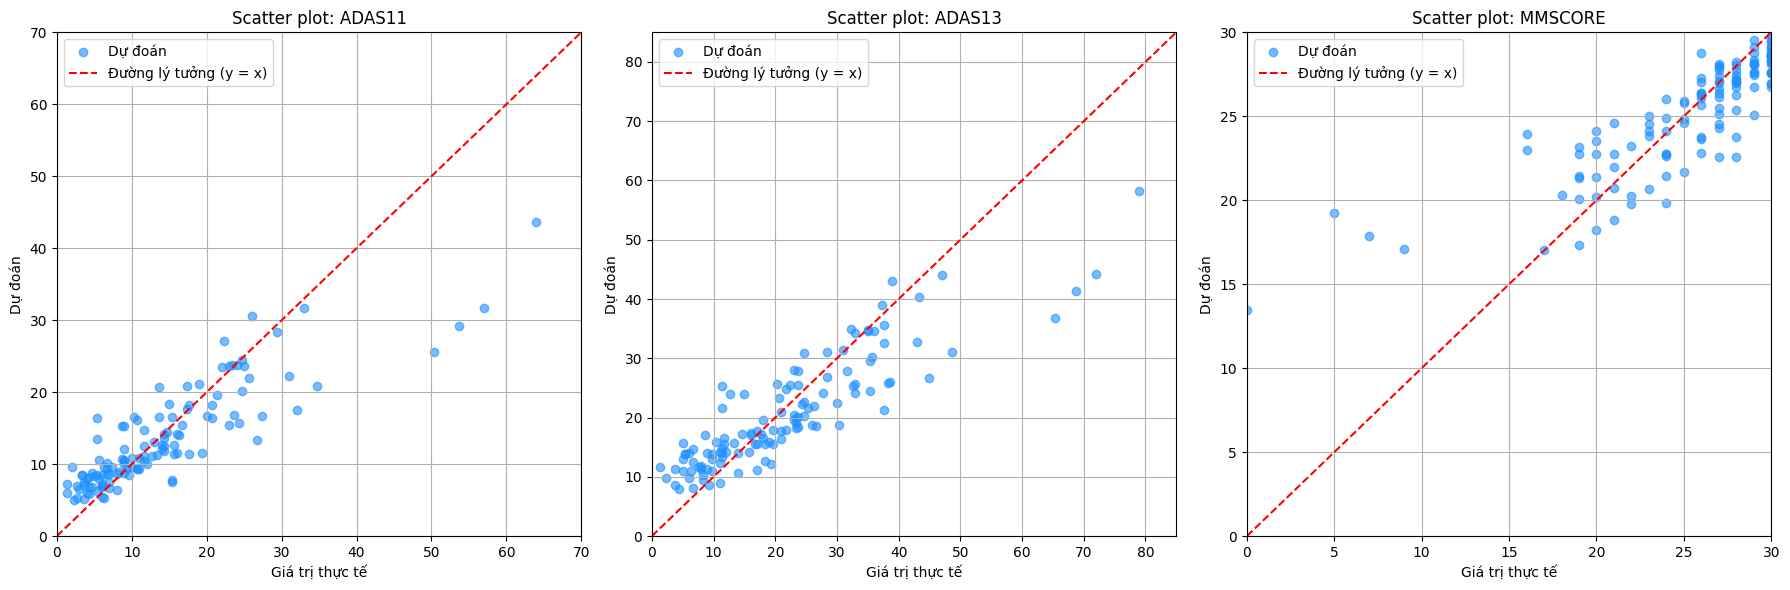

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

ranges = torch.tensor([70, 85, 30]).to(device)  # Scale cho ADAS11, ADAS13, MMSCORE

test_model.eval()

# Để tính độ lệch trung bình
all_out_now = []
all_out_future = []
all_y_now = []
all_y_future = []

test_iter = iter(test_loader)
for i in range(len(test_loader)):
    ((test_mri, test_clinical, test_time_lapse), test_label) = next(test_iter)
    test_mri, test_clinical, test_label, test_time_lapse = (
        test_mri.to(device),
        test_clinical.to(device),
        test_label.to(device),
        test_time_lapse.to(device),
    )

    y_now = test_label[:,0:3]

    with torch.inference_mode():
        (
            adas11_future,
            adas13_future,
            mmscore_future,
        ) = test_model(test_mri, test_clinical, test_time_lapse.unsqueeze(dim=1), y_now)

        out_future = torch.cat((adas11_future, adas13_future, mmscore_future), dim=1)

        out_future_scaled = out_future * ranges
        y_future_scaled = test_label[:, 3:] * ranges

        all_out_future.append(out_future_scaled)
        all_y_future.append(y_future_scaled)

        for idx in range(test_label.shape[0]):
            print(f"🧍‍♂️ Bệnh nhân {i+1}.{idx+1}")
            print(f"• Dự đoán tương lai  : {out_future_scaled[idx].cpu().numpy().tolist()}")
            print(f"• Thực tế tương lai   : {y_future_scaled[idx].cpu().numpy().tolist()}")
            print()

# Gộp tất cả để tính MAE
out_future_all = torch.cat(all_out_future, dim=0)
y_future_all = torch.cat(all_y_future, dim=0)

y_future_np = y_future_all.cpu().numpy()
out_future_np = out_future_all.cpu().numpy()

mae_future = torch.abs(out_future_all - y_future_all).mean(dim=0)

print("📊 Độ lệch trung bình (MAE):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {mae_future[0]:.2f} điểm")
print(f"  - ADAS13  : {mae_future[1]:.2f} điểm")
print(f"  - MMSCORE : {mae_future[2]:.2f} điểm")

# mse_future = F.mse_loss(out_future_all, y_future_all, reduction='none').mean(dim=0)
rmse_future = []
for i in range(3):
    mse_i = mean_squared_error(y_future_np[:, i], out_future_np[:, i])
    rmse_i = mse_i ** 0.5
    rmse_future.append(rmse_i)
rmse_future = torch.tensor(rmse_future)

print("📈 Căn sai số bình phương trung bình (RMSE):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {rmse_future[0]:.2f} điểm")
print(f"  - ADAS13  : {rmse_future[1]:.2f} điểm")
print(f"  - MMSCORE : {rmse_future[2]:.2f} điểm")

r2_future = [r2_score(y_future_np[:, i], out_future_np[:, i]) for i in range(3)]

print("📊 Hệ số xác định (R² Score):")
print(f"• Tương lai:")
print(f"  - ADAS11  : {r2_future[0]:.4f}")
print(f"  - ADAS13  : {r2_future[1]:.4f}")
print(f"  - MMSCORE : {r2_future[2]:.4f}")

import matplotlib.pyplot as plt

labels = ['ADAS11', 'ADAS13', 'MMSCORE']
ranges = [70, 85, 30]  # Max values của từng chỉ số

fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 hàng, 3 cột

for i in range(3):
    max_range = ranges[i]

    axs[i].scatter(y_future_np[:, i], out_future_np[:, i], alpha=0.6, color='dodgerblue', label='Dự đoán')

    # Đường lý tưởng y = x kéo từ 0 đến max_range
    axs[i].plot([0, max_range], [0, max_range], color='red', linestyle='--', label='Đường lý tưởng (y = x)')

    # Giới hạn trục để hiển thị toàn bộ range
    axs[i].set_xlim(0, max_range)
    axs[i].set_ylim(0, max_range)

    axs[i].set_xlabel('Giá trị thực tế')
    axs[i].set_ylabel('Dự đoán')
    axs[i].set_title(f'Scatter plot: {labels[i]}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()